In [245]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt




In [246]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [247]:

class EEGDataset(Dataset):
    def __init__(self, data_dir, max_len=25):
        self.all_data = []
        self.labels = []
        self.max_len = max_len
        
        # Load the EEG data from CSV files in the given directory
        for file in os.listdir(data_dir):
            filename = os.fsdecode(file)
            if filename.endswith('.csv'):
                patient_file_path = os.path.join(data_dir, filename)
                data = pd.read_csv(patient_file_path)

                # Map 'Event' column to numerical labels for clustering
                label = data['Event'].map({'R': 0, 'M': 1, 'F': 2}).values

                # Standardize specific columns
                standardize_list = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 
                                    'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N', 
                                    'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 
                                    'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 
                                    'Mean RR', 'Std RR', 'Mean HR', 'Std HR', 'Min HR', 
                                    'Max HR', 'Freq_Slope mean', 'Freq_Slope std']
                
                scaler = StandardScaler()
                data[standardize_list] = scaler.fit_transform(data[standardize_list])

                # Drop 'Event' column and get features for clustering
                features = data.drop(columns=['Event']).values
                seq_len = features.shape[0]
                
                # Pad or truncate sequences to max_len
                if seq_len < self.max_len:
                    pad_width = self.max_len - seq_len
                    features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
                    label = np.pad(label, (0, pad_width), mode='constant', constant_values=-1) 
                elif seq_len > self.max_len:
                    features = features[:self.max_len, :]
                    label = label[:self.max_len]

                # Append the processed features and labels to the dataset
                self.all_data.append(features)
                self.labels.append(label)

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        # Return the features and labels as tensors
        features = torch.tensor(self.all_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label

In [250]:
path = 'CSV_features_NEW'
folder = 'C:\\Users\\RJEN0307\\Desktop\\Bachelorprojekt\\Bachelor_project_2024\\'

# Combine them using os.path.join for proper path handling
full_path = os.path.join(folder, path)

data_dir = full_path
eeg_dataset = EEGDataset(data_dir, max_len=25)

train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = random_split(eeg_dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for features, labels in train_loader:
    print(f"Features shape: {features.shape}")  #[batch_size, max_len, num_features]
    print(f"Labels shape: {labels.shape}")  #[batch_size, max_len]
    break


Features shape: torch.Size([8, 25, 26])
Labels shape: torch.Size([8, 25])


In [251]:
# Print number of batches
print(f"Total samples: {len(eeg_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


Total samples: 74
Training samples: 59
Testing samples: 15
Number of training batches: 8
Number of testing batches: 2


In [252]:
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEGNet, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device) 
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device) 
        
        out, _ = self.lstm(x, (h0, c0))  #[batch_size, sequence_length, hidden_size]

        out = self.fc(out)  #[batch_size, sequence_length, num_classes]
        
        return out


In [253]:
input_size = eeg_dataset[0][0].shape[1]
hidden_size = 16  
num_layers = 2  
num_classes = 3  # ('R', 'M', 'F')

model = EEGNet(input_size, hidden_size, num_layers, num_classes)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(model)


EEGNet(
  (lstm): LSTM(26, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


In [254]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [255]:
train_losses = []
test_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad() 

        outputs = model(features)

        outputs = outputs.view(-1, num_classes)
        labels = labels.view(-1)

        mask = labels != -1
        masked_outputs = outputs[mask]
        masked_labels = labels[mask]

        loss = criterion(masked_outputs, masked_labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)

            outputs = outputs.view(-1, num_classes)
            labels = labels.view(-1)

            mask = labels != -1
            masked_outputs = outputs[mask]
            masked_labels = labels[mask]

            loss = criterion(masked_outputs, masked_labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}')

print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of test_losses: {len(test_losses)}")



Epoch [1/100], Training Loss: 1.0895, Validation Loss: 1.0670
Epoch [2/100], Training Loss: 1.0507, Validation Loss: 1.0280
Epoch [3/100], Training Loss: 1.0083, Validation Loss: 0.9834
Epoch [4/100], Training Loss: 0.9604, Validation Loss: 0.9348
Epoch [5/100], Training Loss: 0.9112, Validation Loss: 0.8871
Epoch [6/100], Training Loss: 0.8623, Validation Loss: 0.8413
Epoch [7/100], Training Loss: 0.8142, Validation Loss: 0.7884
Epoch [8/100], Training Loss: 0.7498, Validation Loss: 0.7104
Epoch [9/100], Training Loss: 0.6649, Validation Loss: 0.6166
Epoch [10/100], Training Loss: 0.5786, Validation Loss: 0.5375
Epoch [11/100], Training Loss: 0.5072, Validation Loss: 0.4742
Epoch [12/100], Training Loss: 0.4530, Validation Loss: 0.4265
Epoch [13/100], Training Loss: 0.4064, Validation Loss: 0.3868
Epoch [14/100], Training Loss: 0.3714, Validation Loss: 0.3557
Epoch [15/100], Training Loss: 0.3407, Validation Loss: 0.3296
Epoch [16/100], Training Loss: 0.3170, Validation Loss: 0.3108
E

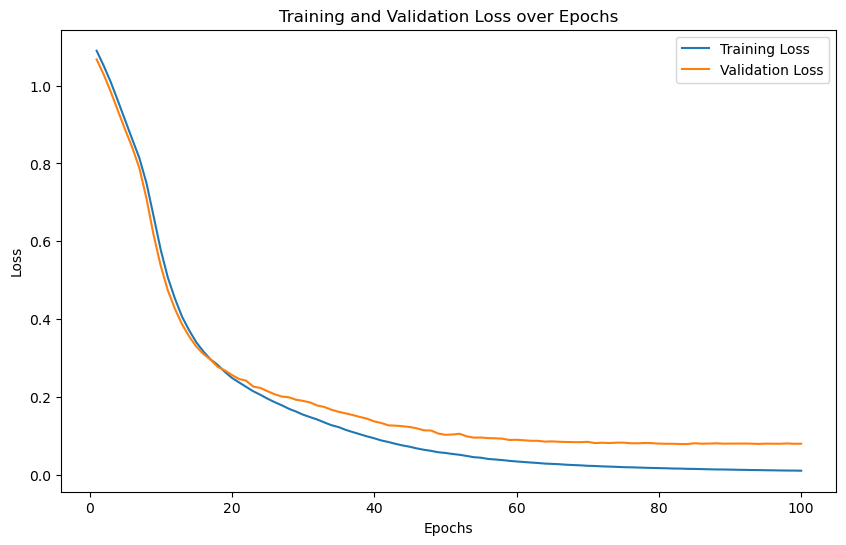

In [256]:
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


Epoch [1/1000], Loss: 1.8451
Epoch [2/1000], Loss: 1.7476
Epoch [3/1000], Loss: 1.6071
Epoch [4/1000], Loss: 1.5165
Epoch [5/1000], Loss: 1.4840
Epoch [6/1000], Loss: 1.4616
Epoch [7/1000], Loss: 1.4320
Epoch [8/1000], Loss: 1.4059
Epoch [9/1000], Loss: 1.3941
Epoch [10/1000], Loss: 1.3891
Epoch [11/1000], Loss: 1.3742
Epoch [12/1000], Loss: 1.3578
Epoch [13/1000], Loss: 1.3401
Epoch [14/1000], Loss: 1.3241
Epoch [15/1000], Loss: 1.3124
Epoch [16/1000], Loss: 1.3028
Epoch [17/1000], Loss: 1.2937
Epoch [18/1000], Loss: 1.2868
Epoch [19/1000], Loss: 1.2814
Epoch [20/1000], Loss: 1.2783
Epoch [21/1000], Loss: 1.2733
Epoch [22/1000], Loss: 1.2702
Epoch [23/1000], Loss: 1.2665
Epoch [24/1000], Loss: 1.2564
Epoch [25/1000], Loss: 1.2569
Epoch [26/1000], Loss: 1.2507
Epoch [27/1000], Loss: 1.2479
Epoch [28/1000], Loss: 1.2417
Epoch [29/1000], Loss: 1.2370
Epoch [30/1000], Loss: 1.2314
Epoch [31/1000], Loss: 1.2270
Epoch [32/1000], Loss: 1.2202
Epoch [33/1000], Loss: 1.2125
Epoch [34/1000], Lo

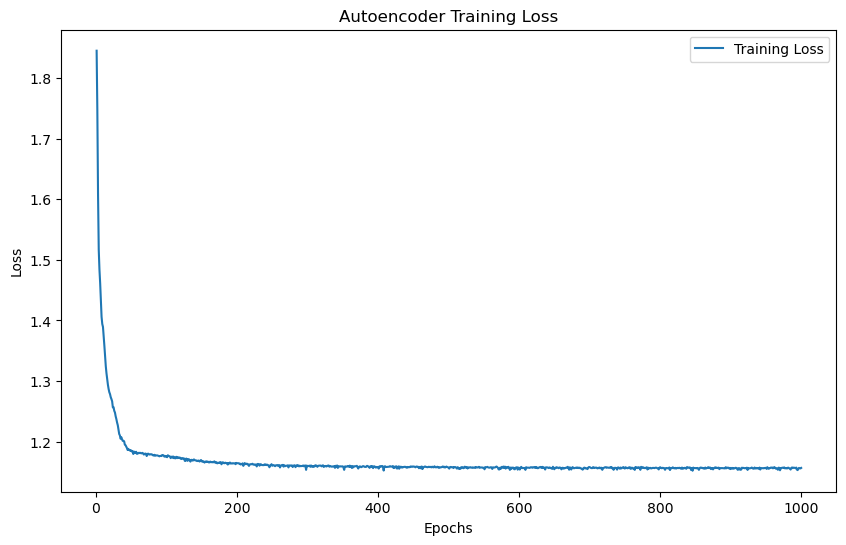

In [257]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

# Hyperparameters
input_size = eeg_dataset[0][0].shape[1]
hidden_size = 128
latent_size = 32 
num_epochs = 1000
learning_rate = 0.001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(input_size, hidden_size, latent_size).to(device)


criterion = nn.MSELoss() 
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


train_losses = []
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for features, _ in train_loader:
        features = features.to(device)
        
        reconstruction, latent = autoencoder(features)
        
        loss = criterion(reconstruction, features)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()


c:\Users\RJEN0307\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


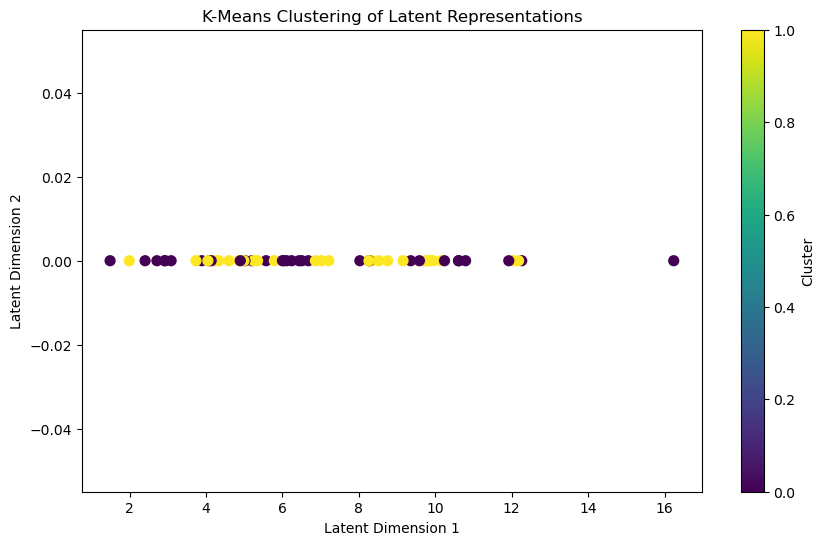

In [258]:
autoencoder.eval() 
latent_representations = []

with torch.no_grad():
    for features, _ in train_loader:
        features = features.to(device)
        _, latent = autoencoder(features)
        latent_representations.append(latent.cpu().numpy())


latent_representations = np.concatenate(latent_representations, axis=0)
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(latent_representations_reshaped)


plt.figure(figsize=(10, 6))
plt.scatter(latent_representations_reshaped[:, 0], latent_representations_reshaped[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Latent Representations')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


**Autoencoders**

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


In [ ]:

# Define a deeper Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        return self.encoder(x)



In [ ]:

#K-Means Clustering
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(latent_representations_reshaped)

unique, counts = np.unique(kmeans_clusters, return_counts=True)
print(f"K-Means Cluster Distribution: {dict(zip(unique, counts))}")

# GMM Clustering
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(latent_representations_reshaped)

gmm_cluster_counts = Counter(gmm_clusters)
print(f"GMM Cluster Distribution: {gmm_cluster_counts}")

# Evaluate clustering quality with silhouette score
kmeans_silhouette = silhouette_score(latent_representations_reshaped, kmeans_clusters)
gmm_silhouette = silhouette_score(latent_representations_reshaped, gmm_clusters)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"GMM Silhouette Score: {gmm_silhouette}")


In [ ]:
input_size = eeg_dataset[0][0].shape[1]  # Number of features in the EEG data
latent_size = 10  # Size of the latent space
batch_size = 64
num_epochs = 20
learning_rate = 0.001

autoencoder = Autoencoder(input_size, latent_size)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loader = DataLoader(eeg_dataset, batch_size=batch_size, shuffle=True)

autoencoder.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for features, _ in train_loader: 
        optimizer.zero_grad()
        reconstructed = autoencoder(features)
        loss = criterion(reconstructed, features)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

autoencoder.eval()
latent_representations = []
with torch.no_grad():
    for features, _ in train_loader:
        latent = autoencoder.encode(features)
        latent_representations.append(latent)

latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()

In [ ]:

# Dimensionality Reduction for Visualization

## PCA Visualization
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_representations_reshaped)

plt.figure(figsize=(10, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Latent Representations (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=gmm_clusters, cmap='viridis', s=50)
plt.title('GMM Clustering of Latent Representations (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

## t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
latent_tsne = tsne.fit_transform(latent_representations_reshaped)

plt.figure(figsize=(10, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Latent Representations (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=gmm_clusters, cmap='viridis', s=50)
plt.title('GMM Clustering of Latent Representations (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

## UMAP Visualization
reducer = umap.UMAP(n_components=2, random_state=42)
latent_umap = reducer.fit_transform(latent_representations_reshaped)

plt.figure(figsize=(10, 6))
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Latent Representations (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=gmm_clusters, cmap='viridis', s=50)
plt.title('GMM Clustering of Latent Representations (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()


Epoch [1/100], Loss: 1.7535
Epoch [2/100], Loss: 1.7027
Epoch [3/100], Loss: 1.6429
Epoch [4/100], Loss: 1.5881
Epoch [5/100], Loss: 1.5094
Epoch [6/100], Loss: 1.4330
Epoch [7/100], Loss: 1.3513
Epoch [8/100], Loss: 1.2598
Epoch [9/100], Loss: 1.1670
Epoch [10/100], Loss: 1.0507
Epoch [11/100], Loss: 0.9679
Epoch [12/100], Loss: 0.8576
Epoch [13/100], Loss: 0.7856
Epoch [14/100], Loss: 0.7096
Epoch [15/100], Loss: 0.6840
Epoch [16/100], Loss: 0.6424
Epoch [17/100], Loss: 0.6308
Epoch [18/100], Loss: 0.6047
Epoch [19/100], Loss: 0.5969
Epoch [20/100], Loss: 0.5732
Epoch [21/100], Loss: 0.5443
Epoch [22/100], Loss: 0.5114
Epoch [23/100], Loss: 0.4882
Epoch [24/100], Loss: 0.4547
Epoch [25/100], Loss: 0.4412
Epoch [26/100], Loss: 0.4360
Epoch [27/100], Loss: 0.4160
Epoch [28/100], Loss: 0.4063
Epoch [29/100], Loss: 0.3922
Epoch [30/100], Loss: 0.3517
Epoch [31/100], Loss: 0.3479
Epoch [32/100], Loss: 0.3442
Epoch [33/100], Loss: 0.3194
Epoch [34/100], Loss: 0.3221
Epoch [35/100], Loss: 0

c:\Users\RJEN0307\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\RJEN0307\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


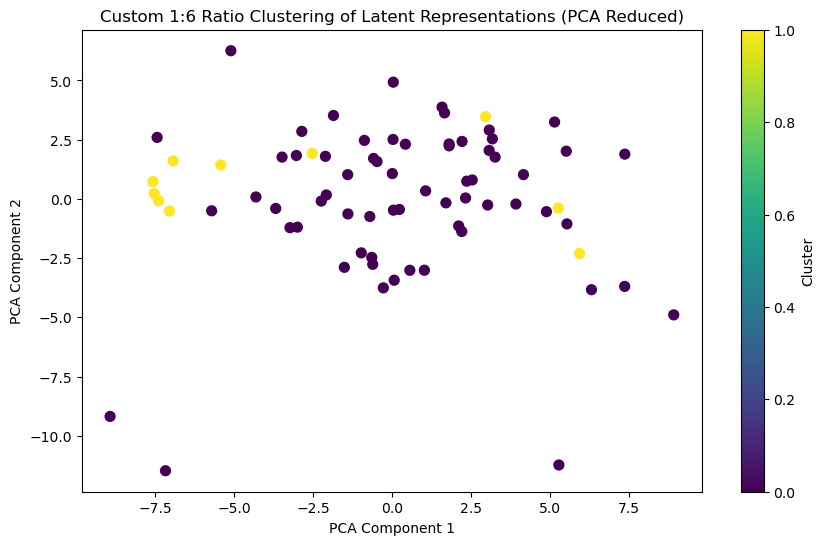

K-Means Silhouette Score (custom ratio): -0.007841600105166435
GMM Silhouette Score: 0.03681400418281555


In [267]:
# DataLoader for batching
batch_size = 64
train_loader = DataLoader(eeg_dataset, batch_size=batch_size, shuffle=True)

# Step 1: Extract latent representations from the dataset using a simple autoencoder
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size, latent_size=10):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        return self.encoder(x)

# Initialize the autoencoder
input_size = eeg_dataset[0][0].shape[1]
autoencoder = SimpleAutoencoder(input_size, latent_size=10)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the autoencoder
num_epochs = 100
autoencoder.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for features, _ in train_loader:  # We don't need labels for unsupervised training
        optimizer.zero_grad()
        reconstructed = autoencoder(features)
        loss = criterion(reconstructed, features)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Extract latent representations
autoencoder.eval()
latent_representations = []
with torch.no_grad():
    for features, _ in train_loader:
        latent = autoencoder.encode(features)
        latent_representations.append(latent)

# Convert latent representations to a single tensor
latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()

# Reshape the latent representations to 2D: [batch_size * sequence_length, latent_dim]
latent_representations_reshaped = latent_representations.reshape(latent_representations.shape[0], -1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(latent_representations_reshaped)

# Perform GMM clustering (alternative)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(latent_representations_reshaped)

# Step 5: Adjusting Cluster Sizes to 1:6 Ratio
# Sort data points by distance to their closest KMeans centroid
distances = kmeans.transform(latent_representations_reshaped)
sorted_indices = np.argsort(np.min(distances, axis=1))

# Manually assign 1:6 ratio to the clusters
threshold = int(len(kmeans_clusters) / 7)  # 1/7th of the total data points for responders
custom_clusters = np.zeros(len(kmeans_clusters), dtype=int)  # Assign most to cluster 1 (non-responders)
custom_clusters[sorted_indices[:threshold]] = 1  # Assign top 1/7 to cluster 1 (responders)

# Step 6: Visualization using PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_representations_reshaped)

plt.figure(figsize=(10, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=custom_clusters, cmap='viridis', s=50)
plt.title('Custom 1:6 Ratio Clustering of Latent Representations (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 7: Evaluate Clustering with Silhouette Score
kmeans_silhouette = silhouette_score(latent_representations_reshaped, custom_clusters)
print(f"K-Means Silhouette Score (custom ratio): {kmeans_silhouette}")

gmm_silhouette = silhouette_score(latent_representations_reshaped, gmm_clusters)
print(f"GMM Silhouette Score: {gmm_silhouette}")
